<a href="https://colab.research.google.com/github/tsdataclinic/redcross-mapswipe/blob/main/notebooks/red_cross_report_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook overview

The purpose of this notebook is to demonstrate the feasibility of a programmatically-generated report that takes MapSwipe Validate data outputs and creates tables, graphs, and maps. The report would be intended to help users understand how MapSwipe raters responded to tasks in the Validate project and which factors may be associated with footprint quality.

The notebook has the following sections:

- Setup
- Descriptive statistics
  - Total tasks
  - Number of responses per task
  - Task years of origin
- Response statistics
  - Modal task responses
  - Responses by task year
  - Maps
- Possible directions for the Red Cross <> Data Clinic collaboration






In [5]:
!pip install git+https://github.com/tsdataclinic/redcross-mapswipe.git#egg=mapswipe

  Cloning https://github.com/tsdataclinic/redcross-mapswipe.git to /tmp/pip-install-w14jhlws/mapswipe_9747f40d9bec42b6b5d1ecde8749caf4
  Running command git clone --filter=blob:none --quiet https://github.com/tsdataclinic/redcross-mapswipe.git /tmp/pip-install-w14jhlws/mapswipe_9747f40d9bec42b6b5d1ecde8749caf4
  Resolved https://github.com/tsdataclinic/redcross-mapswipe.git to commit 4e85f7c1b1c6103eea8e404794edcc42f9b84fb5
  Preparing metadata (setup.py) ... done
  Created wheel for mapswipe: filename=mapswipe-0.1.0-py3-none-any.whl size=1409 sha256=5b5face9eb5fa29de631c23925e4154ff0e3c5faeb12b8dc718afe9b2228b1c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-llyyq4sa/wheels/e6/63/31/1cd6fb59bf4274cd1d851da4e931578c874be9160fd718308b
Successfully built mapswipe


In [8]:
from mapswipe import utils

In [9]:
utils.hello_world()

hello world!


In [ ]:
!pip install h3
import geopandas as gpd
import gzip
from io import BytesIO
import requests
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import h3
import folium
import folium
from shapely.geometry import Polygon
import branca.colormap as cm
from folium.features import GeoJsonTooltip
from plotnine import options
from plotnine import theme_set, themes
from IPython.display import display, Markdown


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.6 MB/s eta 0:00:00


In [ ]:
replacement_dict = {0: "no", 1: "yes", 2: "unsure", 3: "offset"}

def calc_agreement(row: pd.Series) -> float:
    """
    for each task the "agreement" is computed (i.e. the extent to which
    raters agree for the i-th subject). This measure is a component of
    Fleiss' kappa: https://en.wikipedia.org/wiki/Fleiss%27_kappa
    """

    n = row["total_count"]

    row = row.drop(labels=["total_count"])
    # extent to which raters agree for the ith subject
    # set agreement to None if only one user contributed
    if n == 1 or n == 0:
        agreement = None
    else:
        agreement = (sum([i**2 for i in row]) - n) / (n * (n - 1))

    return agreement

def read_agg_results(project_code):
    url = f"https://apps.mapswipe.org/api/agg_results/agg_results_{project_code}_geom.geojson.gz"
    response = requests.get(url)
    gzipped_file = BytesIO(response.content)

    with gzip.GzipFile(fileobj=gzipped_file) as f:
        gdf = gpd.read_file(f)

    gdf = gdf[['idx', 'task_id', '0_count', '1_count', '2_count', '3_count', '0_share', '1_share', '2_share', '3_share',
        'total_count', "lastEdit", "osm_username", "geometry"]]

    gdf["agreement"] = gdf[["total_count", '0_count', '1_count', '2_count', '3_count']].apply(calc_agreement, axis = 1)

    gdf["year"] = gdf["lastEdit"].dt.year
    gdf["modal_answer"] = gdf[['0_count', '1_count', '2_count', '3_count']].idxmax(axis=1)
    gdf["modal_answer"] = gdf["modal_answer"].replace(replacement_dict)
    gdf["yes_building"] = gdf["modal_answer"] == "1_count"

    return gdf

def read_full_results(project_code):
    url = f"https://apps.mapswipe.org/api/results/results_{project_code}.csv.gz"

    response = requests.get(url)
    gzipped_file = BytesIO(response.content)

    with gzip.GzipFile(fileobj=gzipped_file) as f:
        results = pd.read_csv(f)

    results["result"] = results["result"].replace(replacement_dict)

    return results

def create_hex_map(task_gdf, h3_resolution):
    gdf = task_gdf.copy(deep = True)
    gdf["geometry"] = gdf.centroid

    # Define hexagons
    def latlon_to_hexagon(row, resolution):
        return h3.geo_to_h3(row.geometry.y, row.geometry.x, resolution)

    gdf['hexagon'] = gdf.apply(latlon_to_hexagon, resolution=h3_resolution, axis=1)

    hexagon_gdf = gdf.groupby('hexagon').agg({"yes_building" : "mean", "task_id" : "nunique"}).reset_index()

    def hexagon_to_geometry(hexagon):
        vertices = h3.h3_to_geo_boundary(hexagon, geo_json=True)
        return Polygon(vertices)

    hexagon_gdf['geometry'] = hexagon_gdf['hexagon'].apply(hexagon_to_geometry)

    hexagon_gdf = gpd.GeoDataFrame(hexagon_gdf, geometry='geometry').set_crs(4326)

    # Create the map
    m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=8)

    hexagon_geojson = hexagon_gdf.to_json()

    tooltip = GeoJsonTooltip(
        fields=['hexagon', 'task_id', 'yes_building'],
        aliases=['Hexagon ID:', 'Building Count:', "yes_pct"],  # These are the names that will appear in the tooltip
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )


    # Add Choropleth layer
    folium.Choropleth(
        geo_data=hexagon_geojson,
        name='choropleth',
        data=hexagon_gdf,
        columns=['hexagon', 'yes_building'],
        key_on='feature.properties.hexagon',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='% buildings positively identified'
    ).add_to(m)

    folium.GeoJson(
        hexagon_geojson,
        style_function=lambda x: {"fillColor": "YlOrRd", "color": "black", "weight": 1, "fillOpacity":0},
        tooltip=tooltip
    ).add_to(m)

    m._repr_html_ = lambda: m._parent._repr_html_(
    include_link=False, width='75%', height='400px'
    )
    return m

def create_task_map(gdf):

    geojson_data = gdf.drop('lastEdit', axis=1).to_json()

    map = folium.Map(location=[0.5, 0.5], zoom_start=8)
    map._repr_html_ = lambda: map._parent._repr_html_(
    include_link=False, width='75%', height='400px'
    )

    colormap = cm.linear.YlOrRd_09.scale(gdf["1_share"].min(), gdf["1_share"].max())

    def style_function(feature):
        return {
            'fillColor': colormap(feature['properties']['1_share']),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.8
        }

    folium.GeoJson(
        geojson_data,
        style_function=style_function,
        name="geojson"
    ).add_to(map)

    colormap.add_to(map)

    return map

# Mapswipe Validate Report Example

In [ ]:
# Set global options for plotnine to adjust plot sizes
options.figure_size = (12, 8)
theme_set(themes.theme_minimal(base_size=20))

## Setup

Each MapSwipe validate project has a unique code that identifies the project and its associated data outputs.

Here we use the West Africa (Code: NcDh6AxOmfi4gC6XInw) project, but you can run this notebook for any other project by switching out the code below.

In [ ]:
#project_code = "-NdeQ6m1-rSdBtJCh70K" # Nigeria
#project_code = "-NeiT6ffy2UydFQ9iUJu" # Bangladesh
project_code = "-NcDh6AxOmfi4gC6XInw" # West Africa

In [ ]:
task_gdf = read_agg_results(project_code)

## Descriptive Statistics

In this section, we present basic statistics about the tasks included in the project. Each task represents a distinct building footprint that users are asked to evaluated for accuracy.

### Total tasks:

In [ ]:
total_tasks = task_gdf.shape[0]

markdown_text = f"### Total number of tasks: {total_tasks}"
display(Markdown(markdown_text))


### Total number of tasks: 40757

### Number of responses per task

In [ ]:
task_gdf["total_count"].describe()

count    40757.000000
mean        11.725789
std          3.399560
min          9.000000
25%         10.000000
50%         10.000000
75%         12.000000
max         33.000000
Name: total_count, dtype: float64

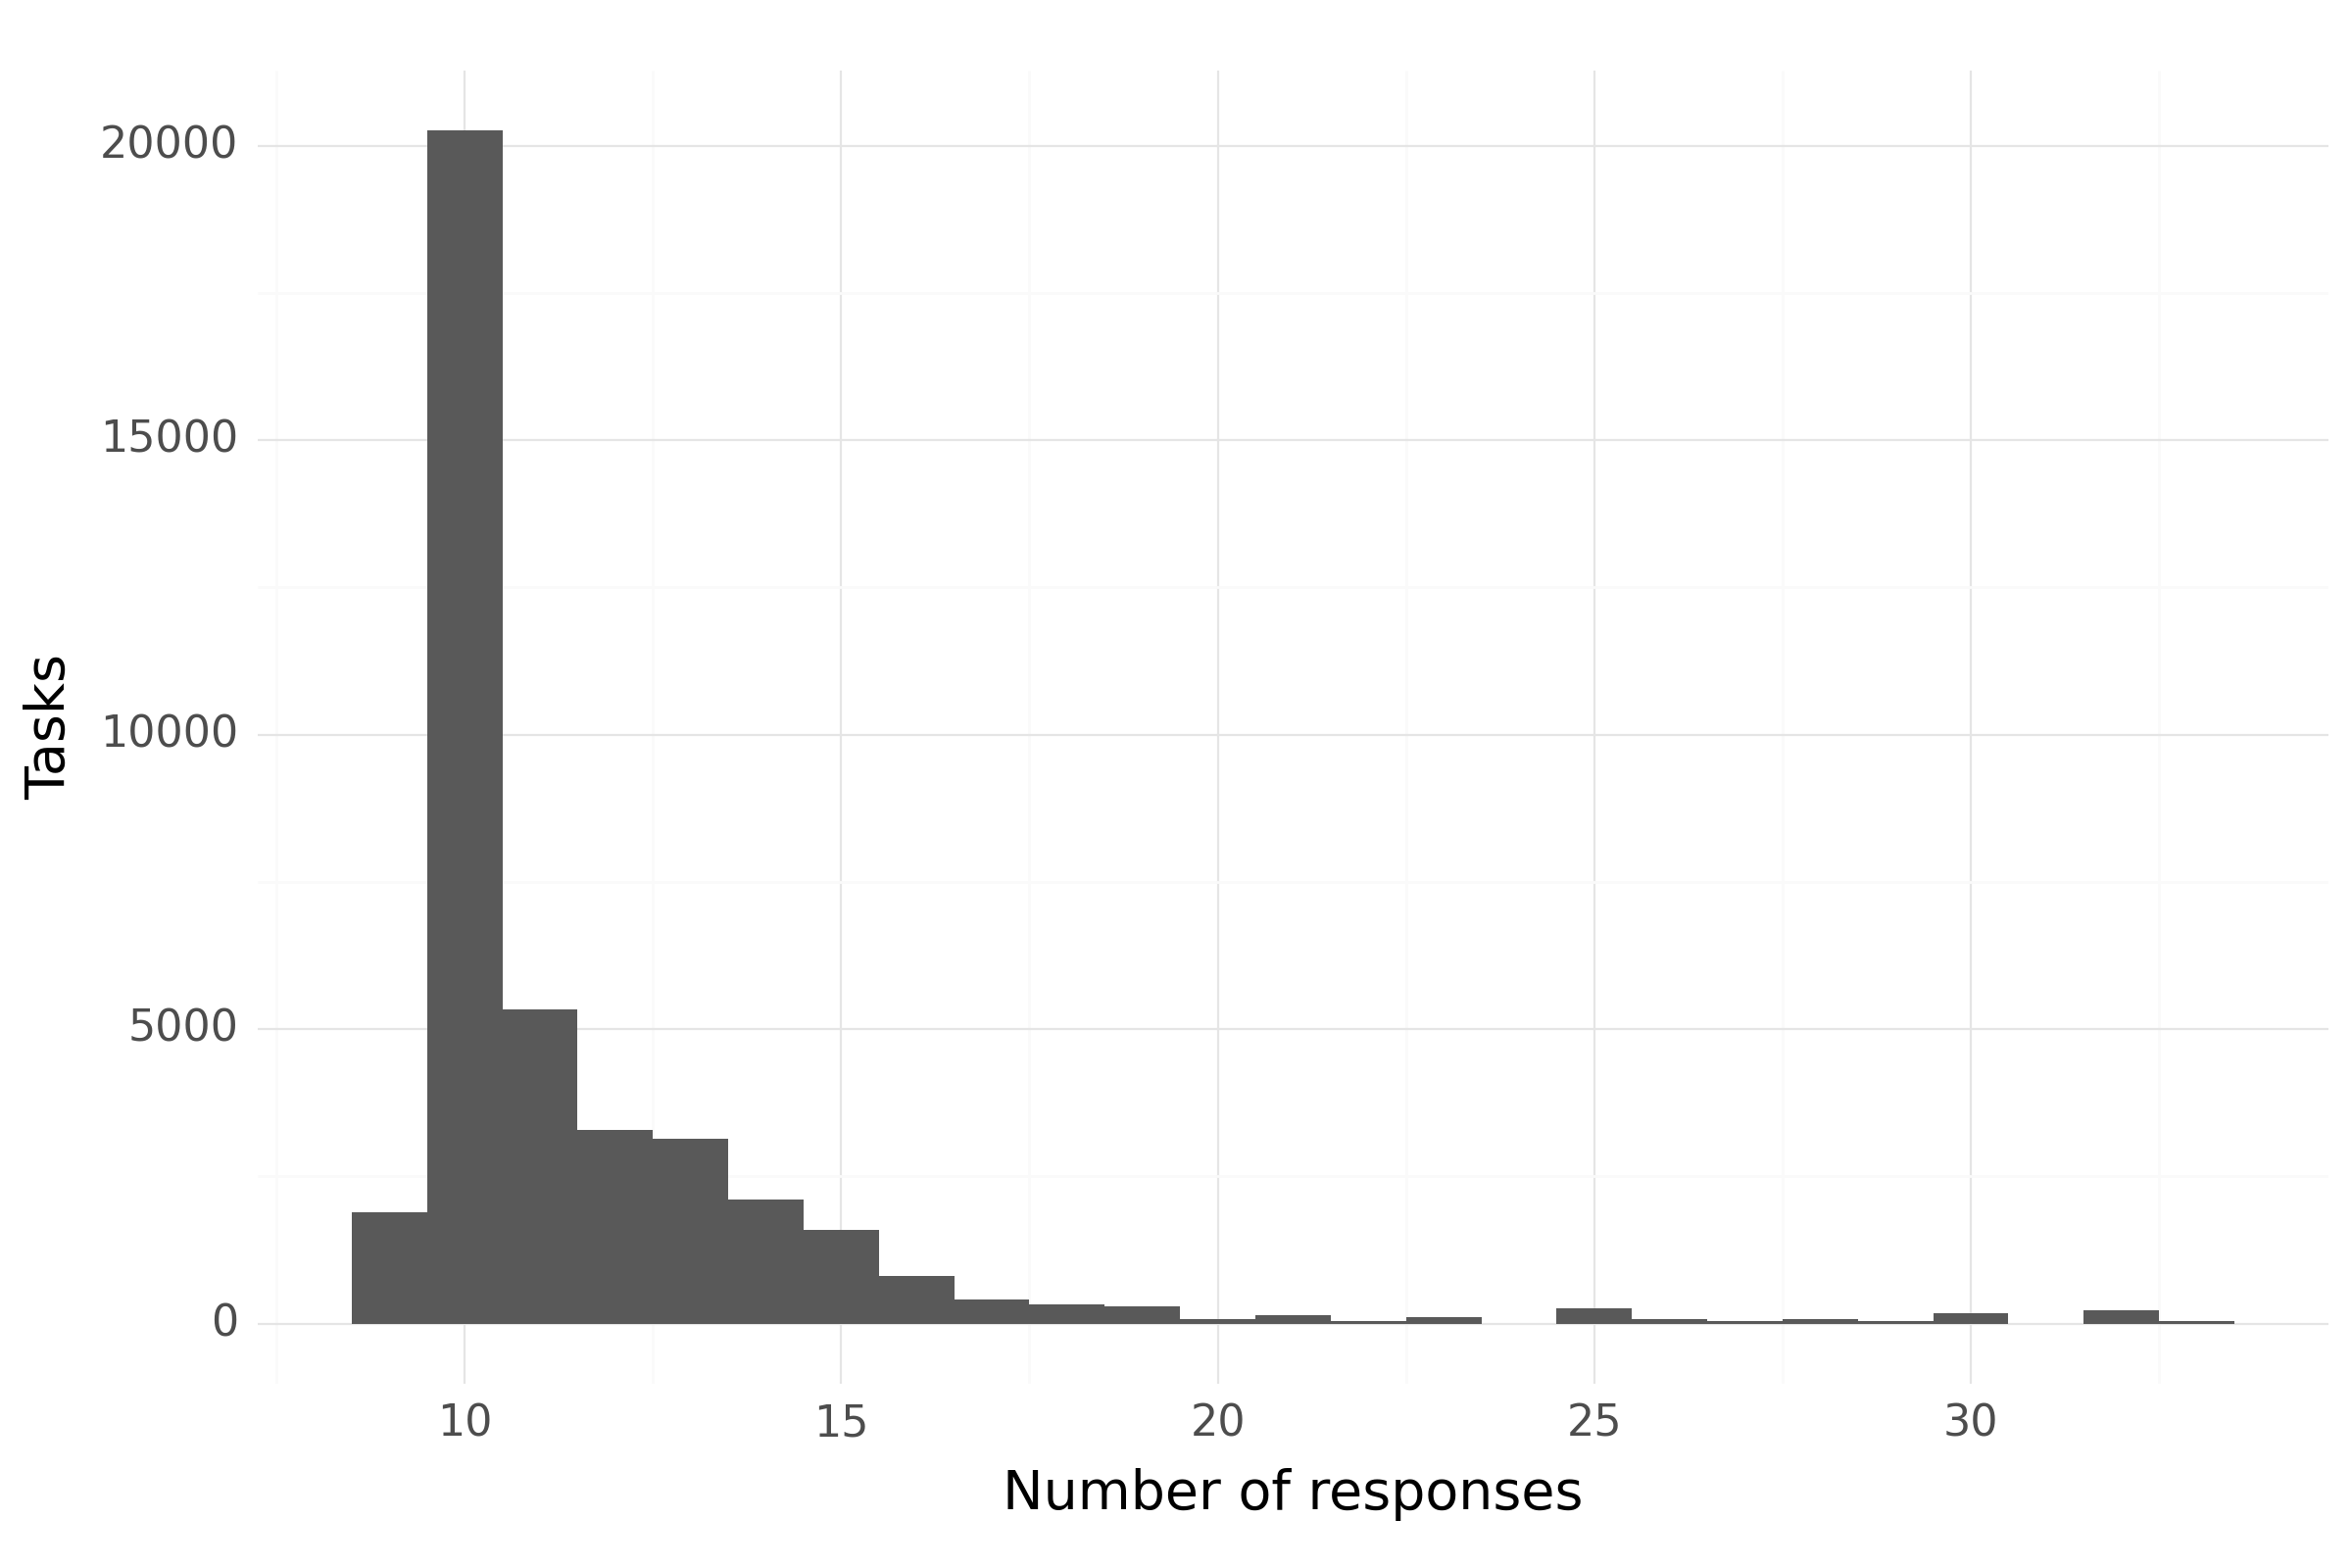

<Figure Size: (1200 x 800)>

In [ ]:
(ggplot(task_gdf, aes(x = "total_count")) + geom_histogram(binwidth = 1) + labs(x = "Number of responses", y = "Tasks"))

### Task years of origin (i.e., when the footprint was added to OSM)

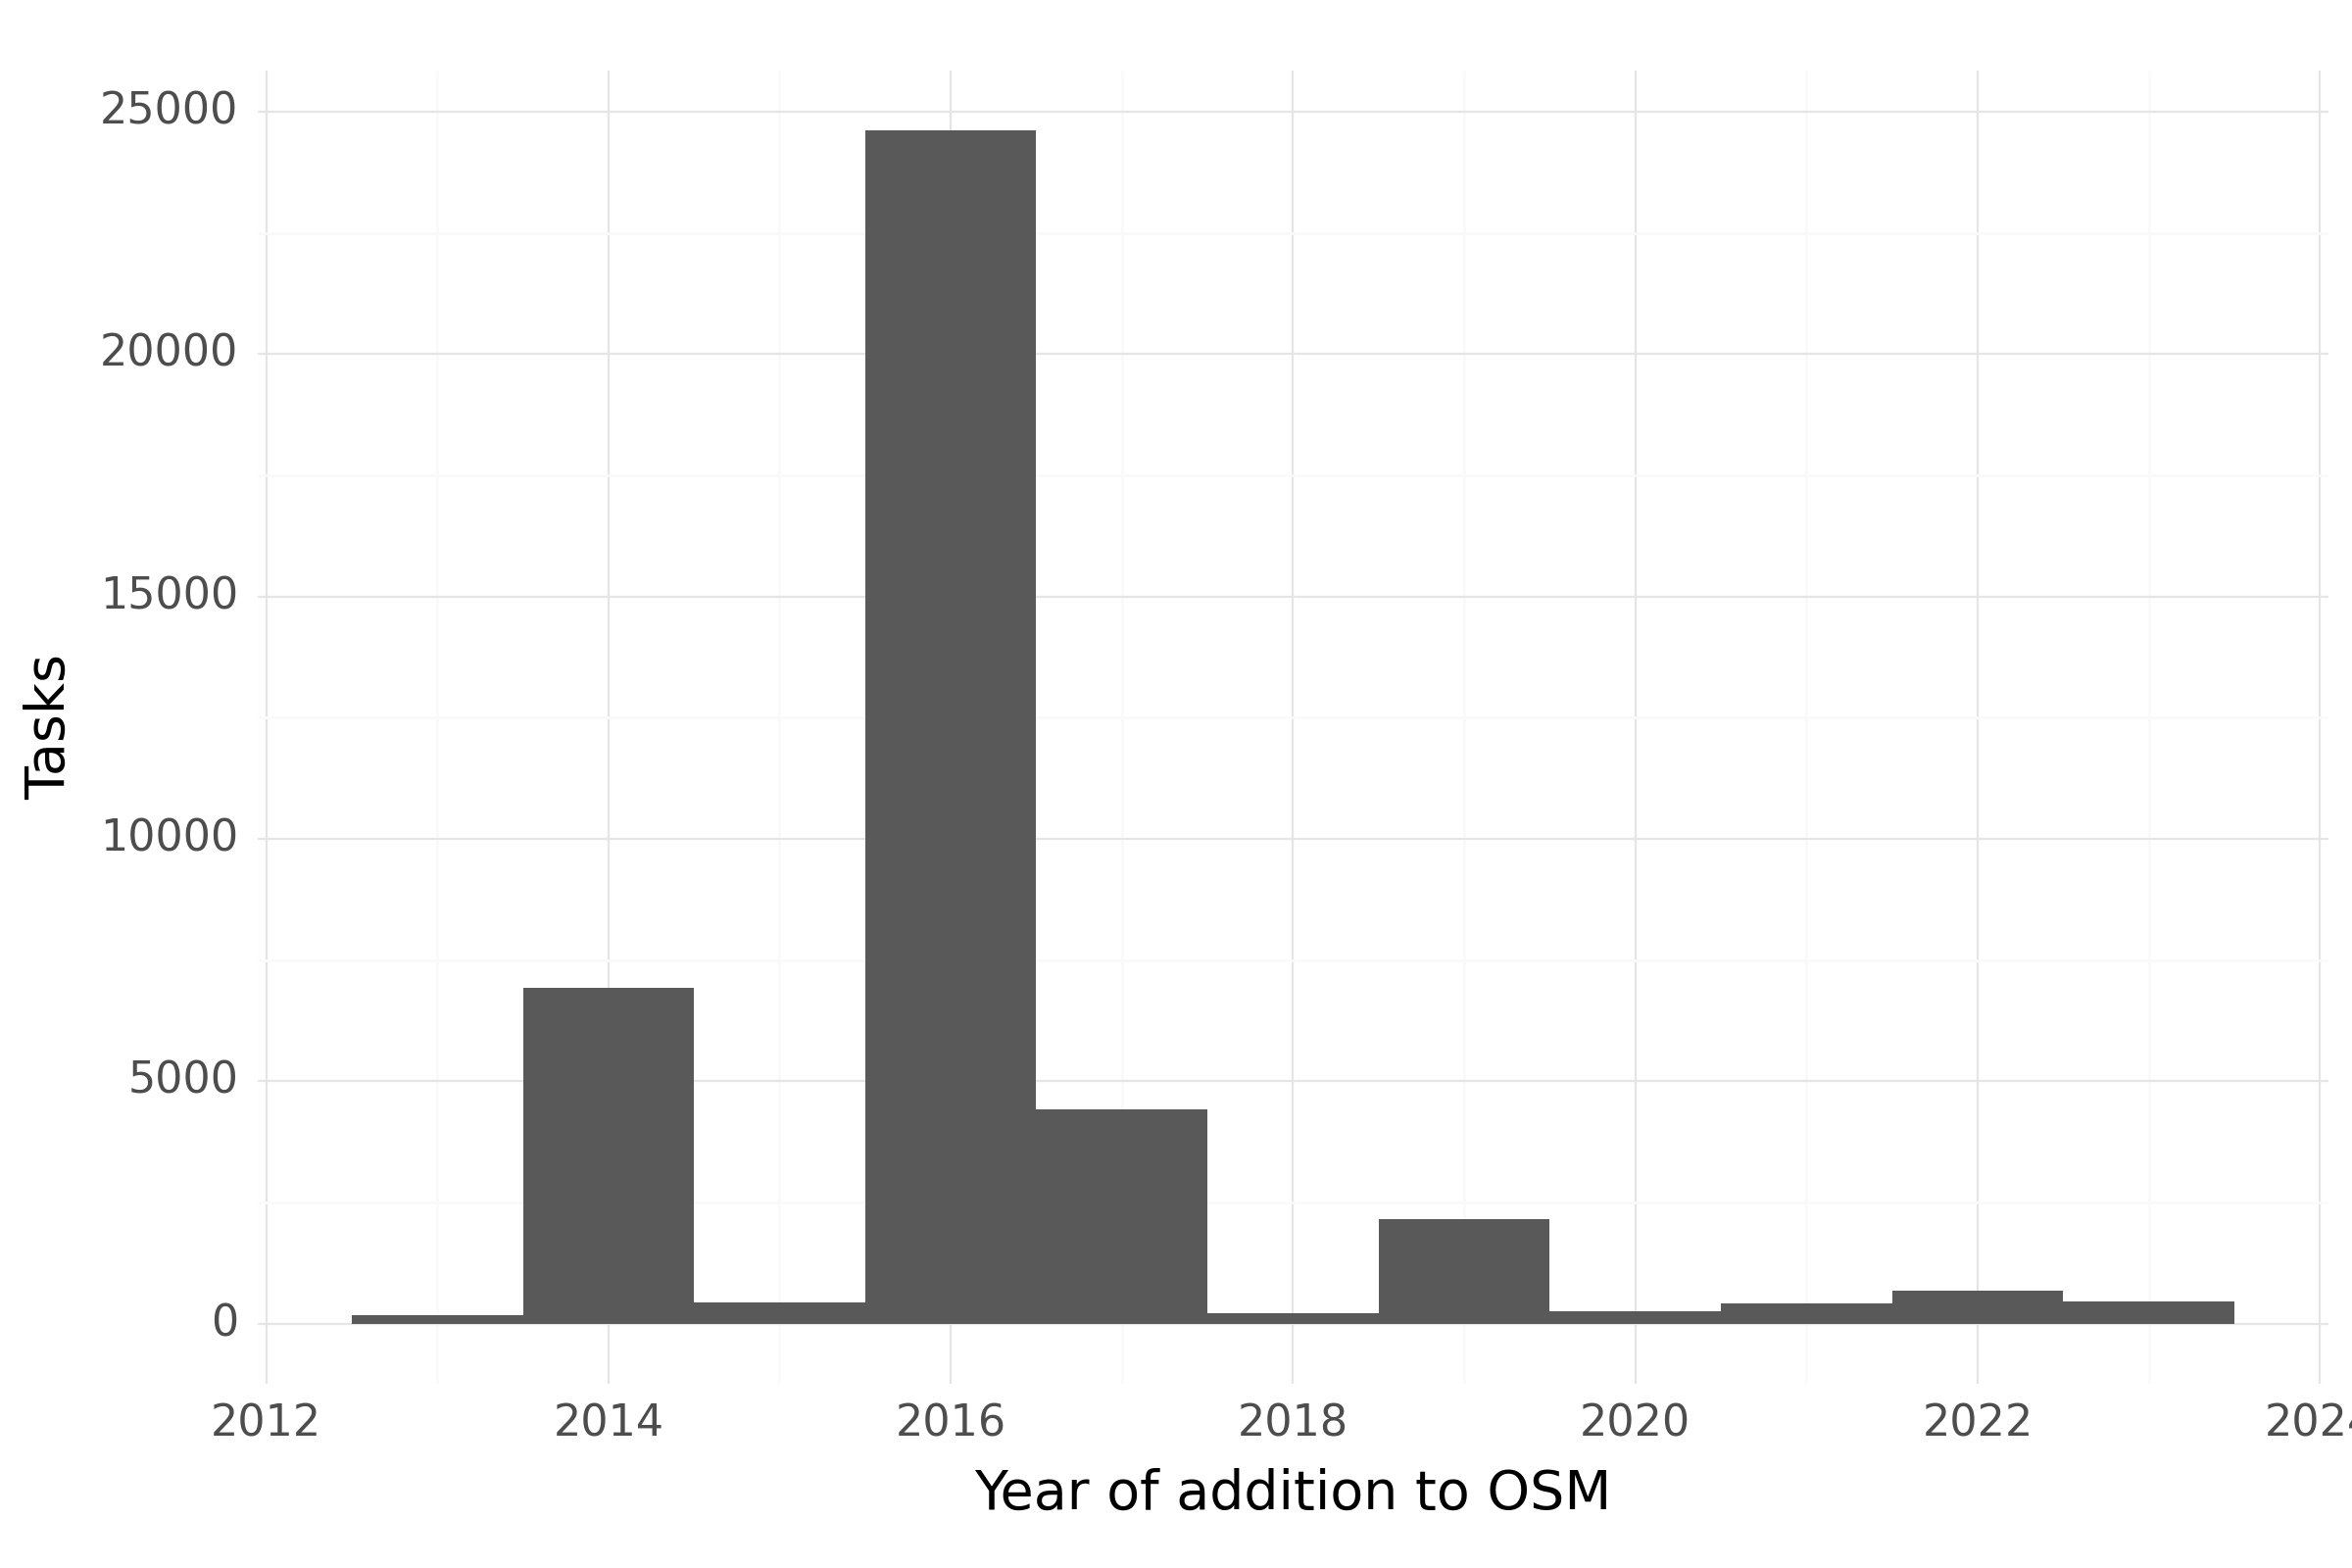

<Figure Size: (1200 x 800)>

In [ ]:

(ggplot(task_gdf, aes(x = "year")) + geom_histogram(binwidth = 1) + labs(x = "Year of addition to OSM", y = "Tasks"))


## Response statistics

This section summarizes the responses across project tasks.

In [ ]:
results = read_full_results(project_code)
results = results.merge(task_gdf[["task_id", "year"]])

### Modal responses

For each task, we can look at the most frequent response.

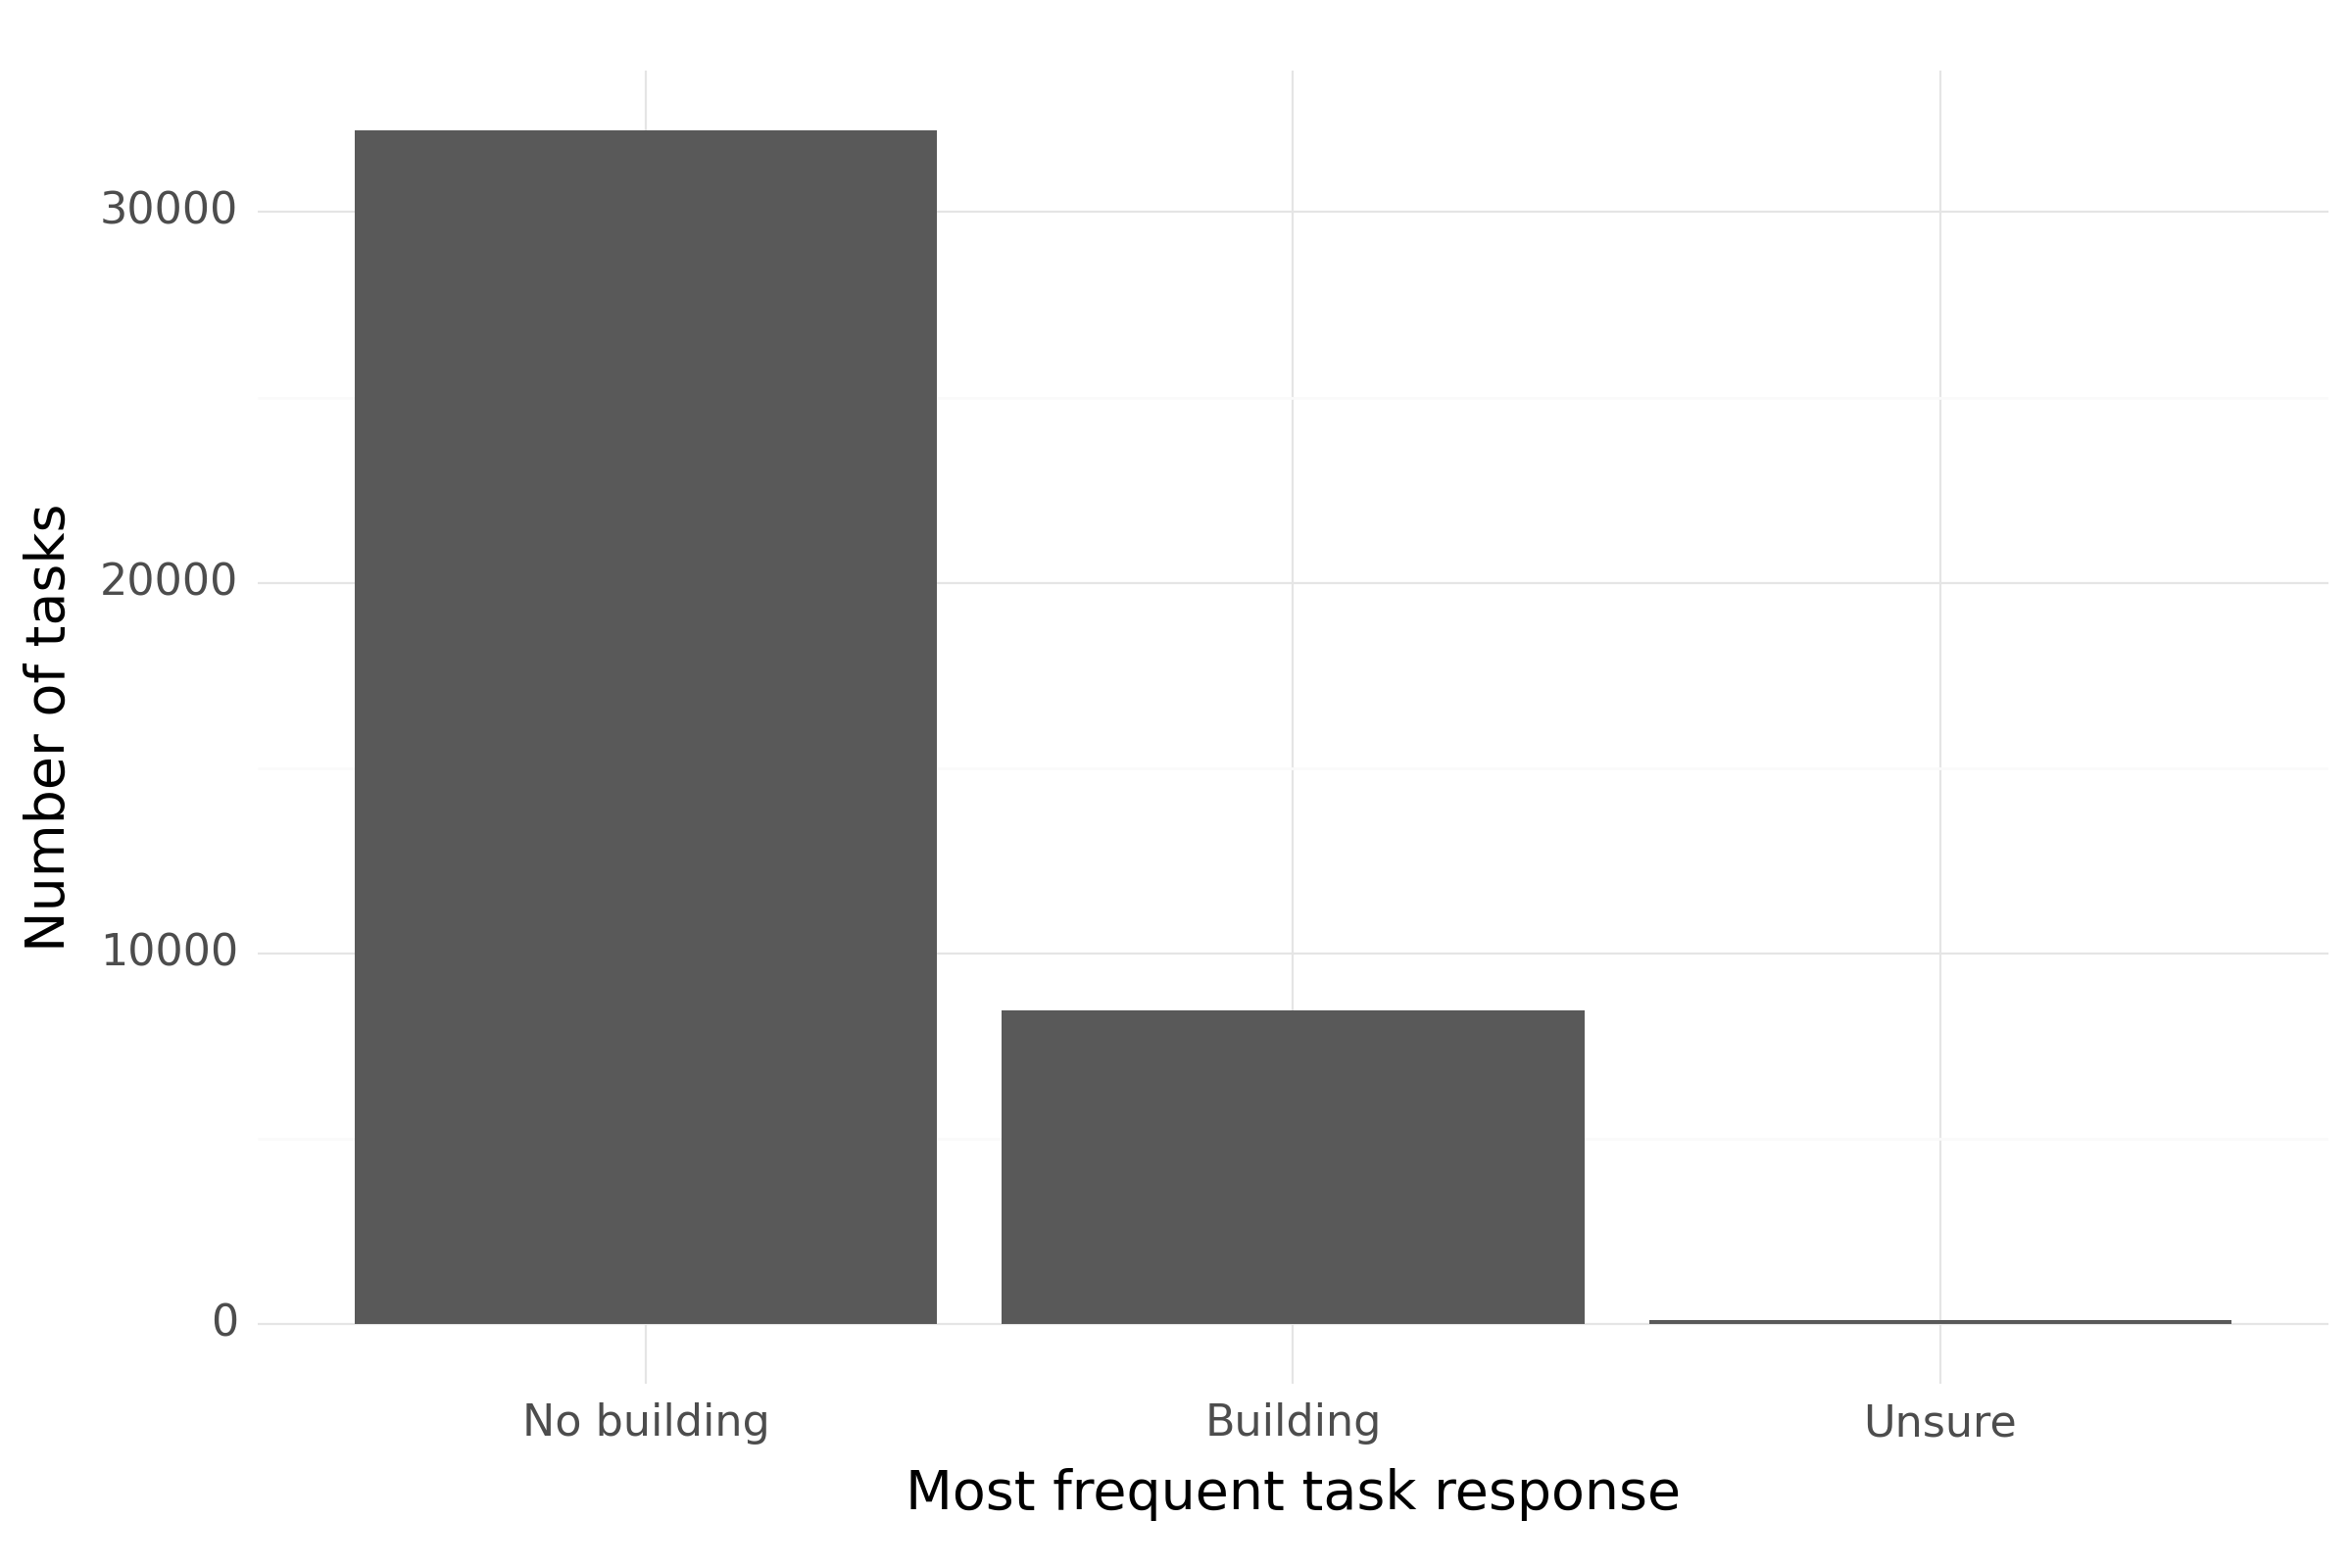

<Figure Size: (1200 x 800)>

In [ ]:
(ggplot(task_gdf, aes(x = "modal_answer")) + geom_bar() + labs(x = "Most frequent task response", y = "Number of tasks") + scale_x_discrete(labels = ["No building", "Building", "Unsure"]))

### Responses by task year

Each footprint's creation date is available in the aggregated results file. This allows us to compare task responses of recently created footprints to those that are older.

In this project, many of the footprints were added to OSM in 2016.

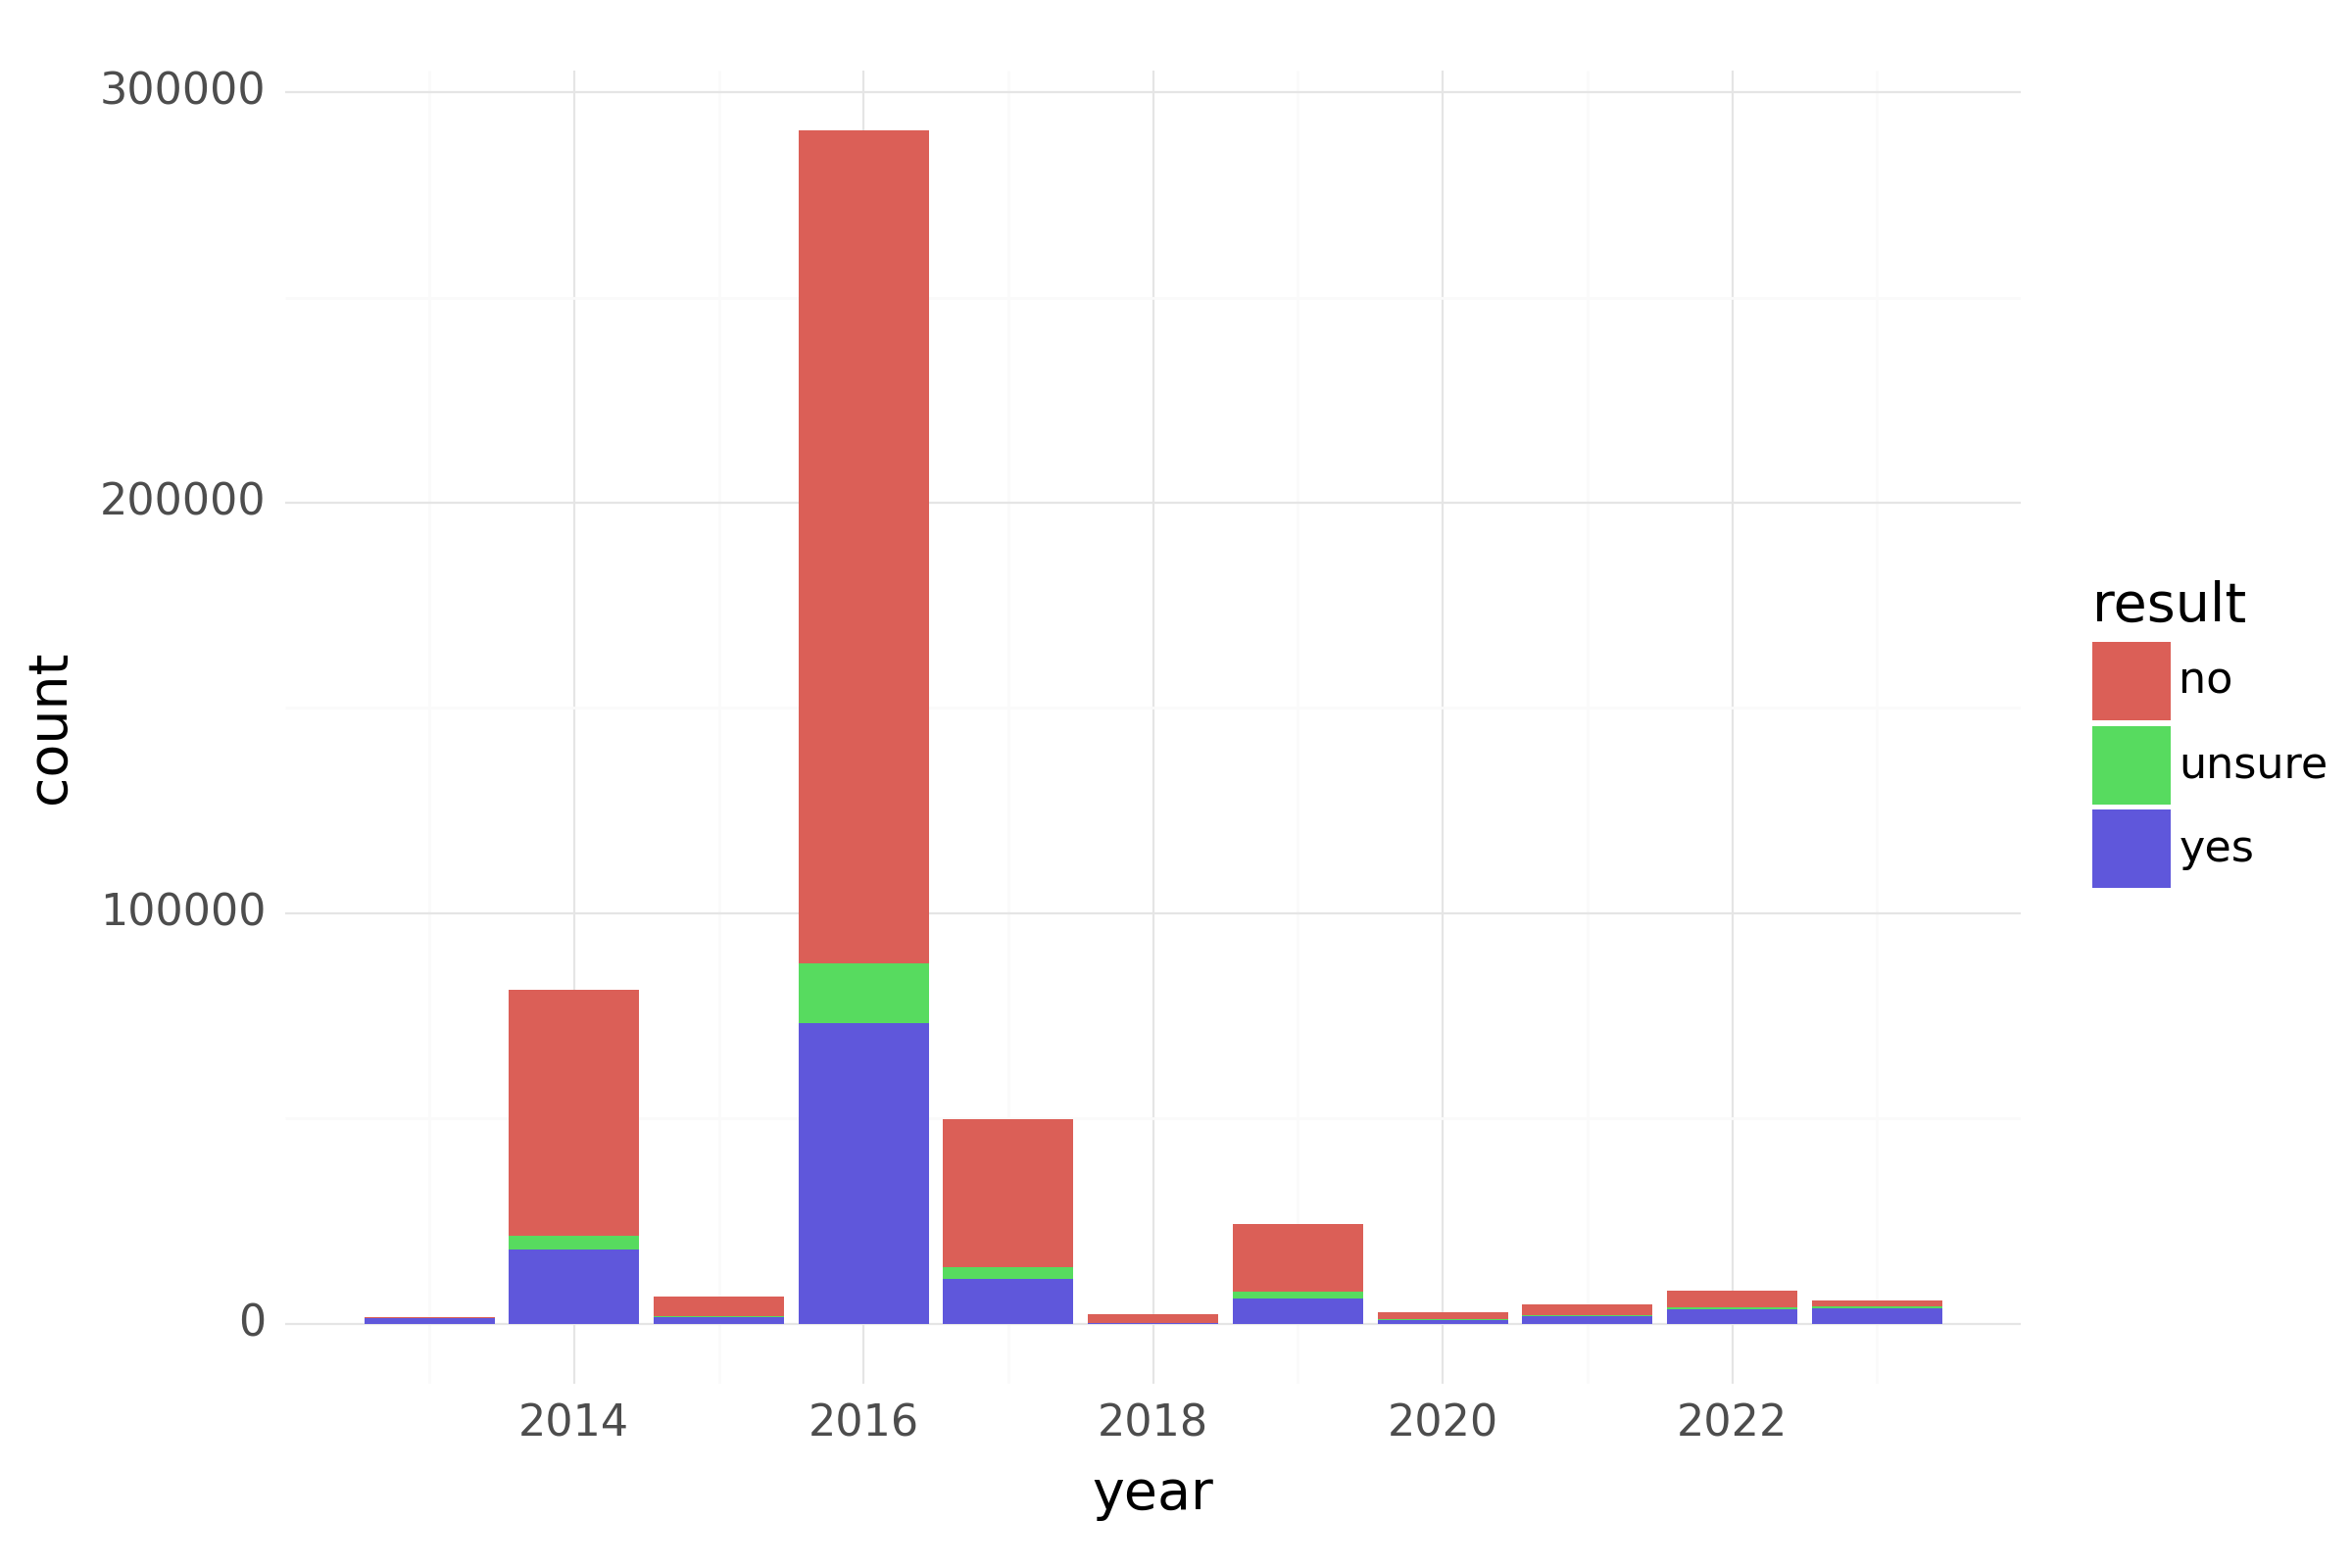

<Figure Size: (1200 x 800)>

In [ ]:
(ggplot(results, aes(x = "year", fill = "result")) + geom_bar())

Though there are a relatively small number of footprints from after 2020, these tasks were more likely to receive affirmative responses.

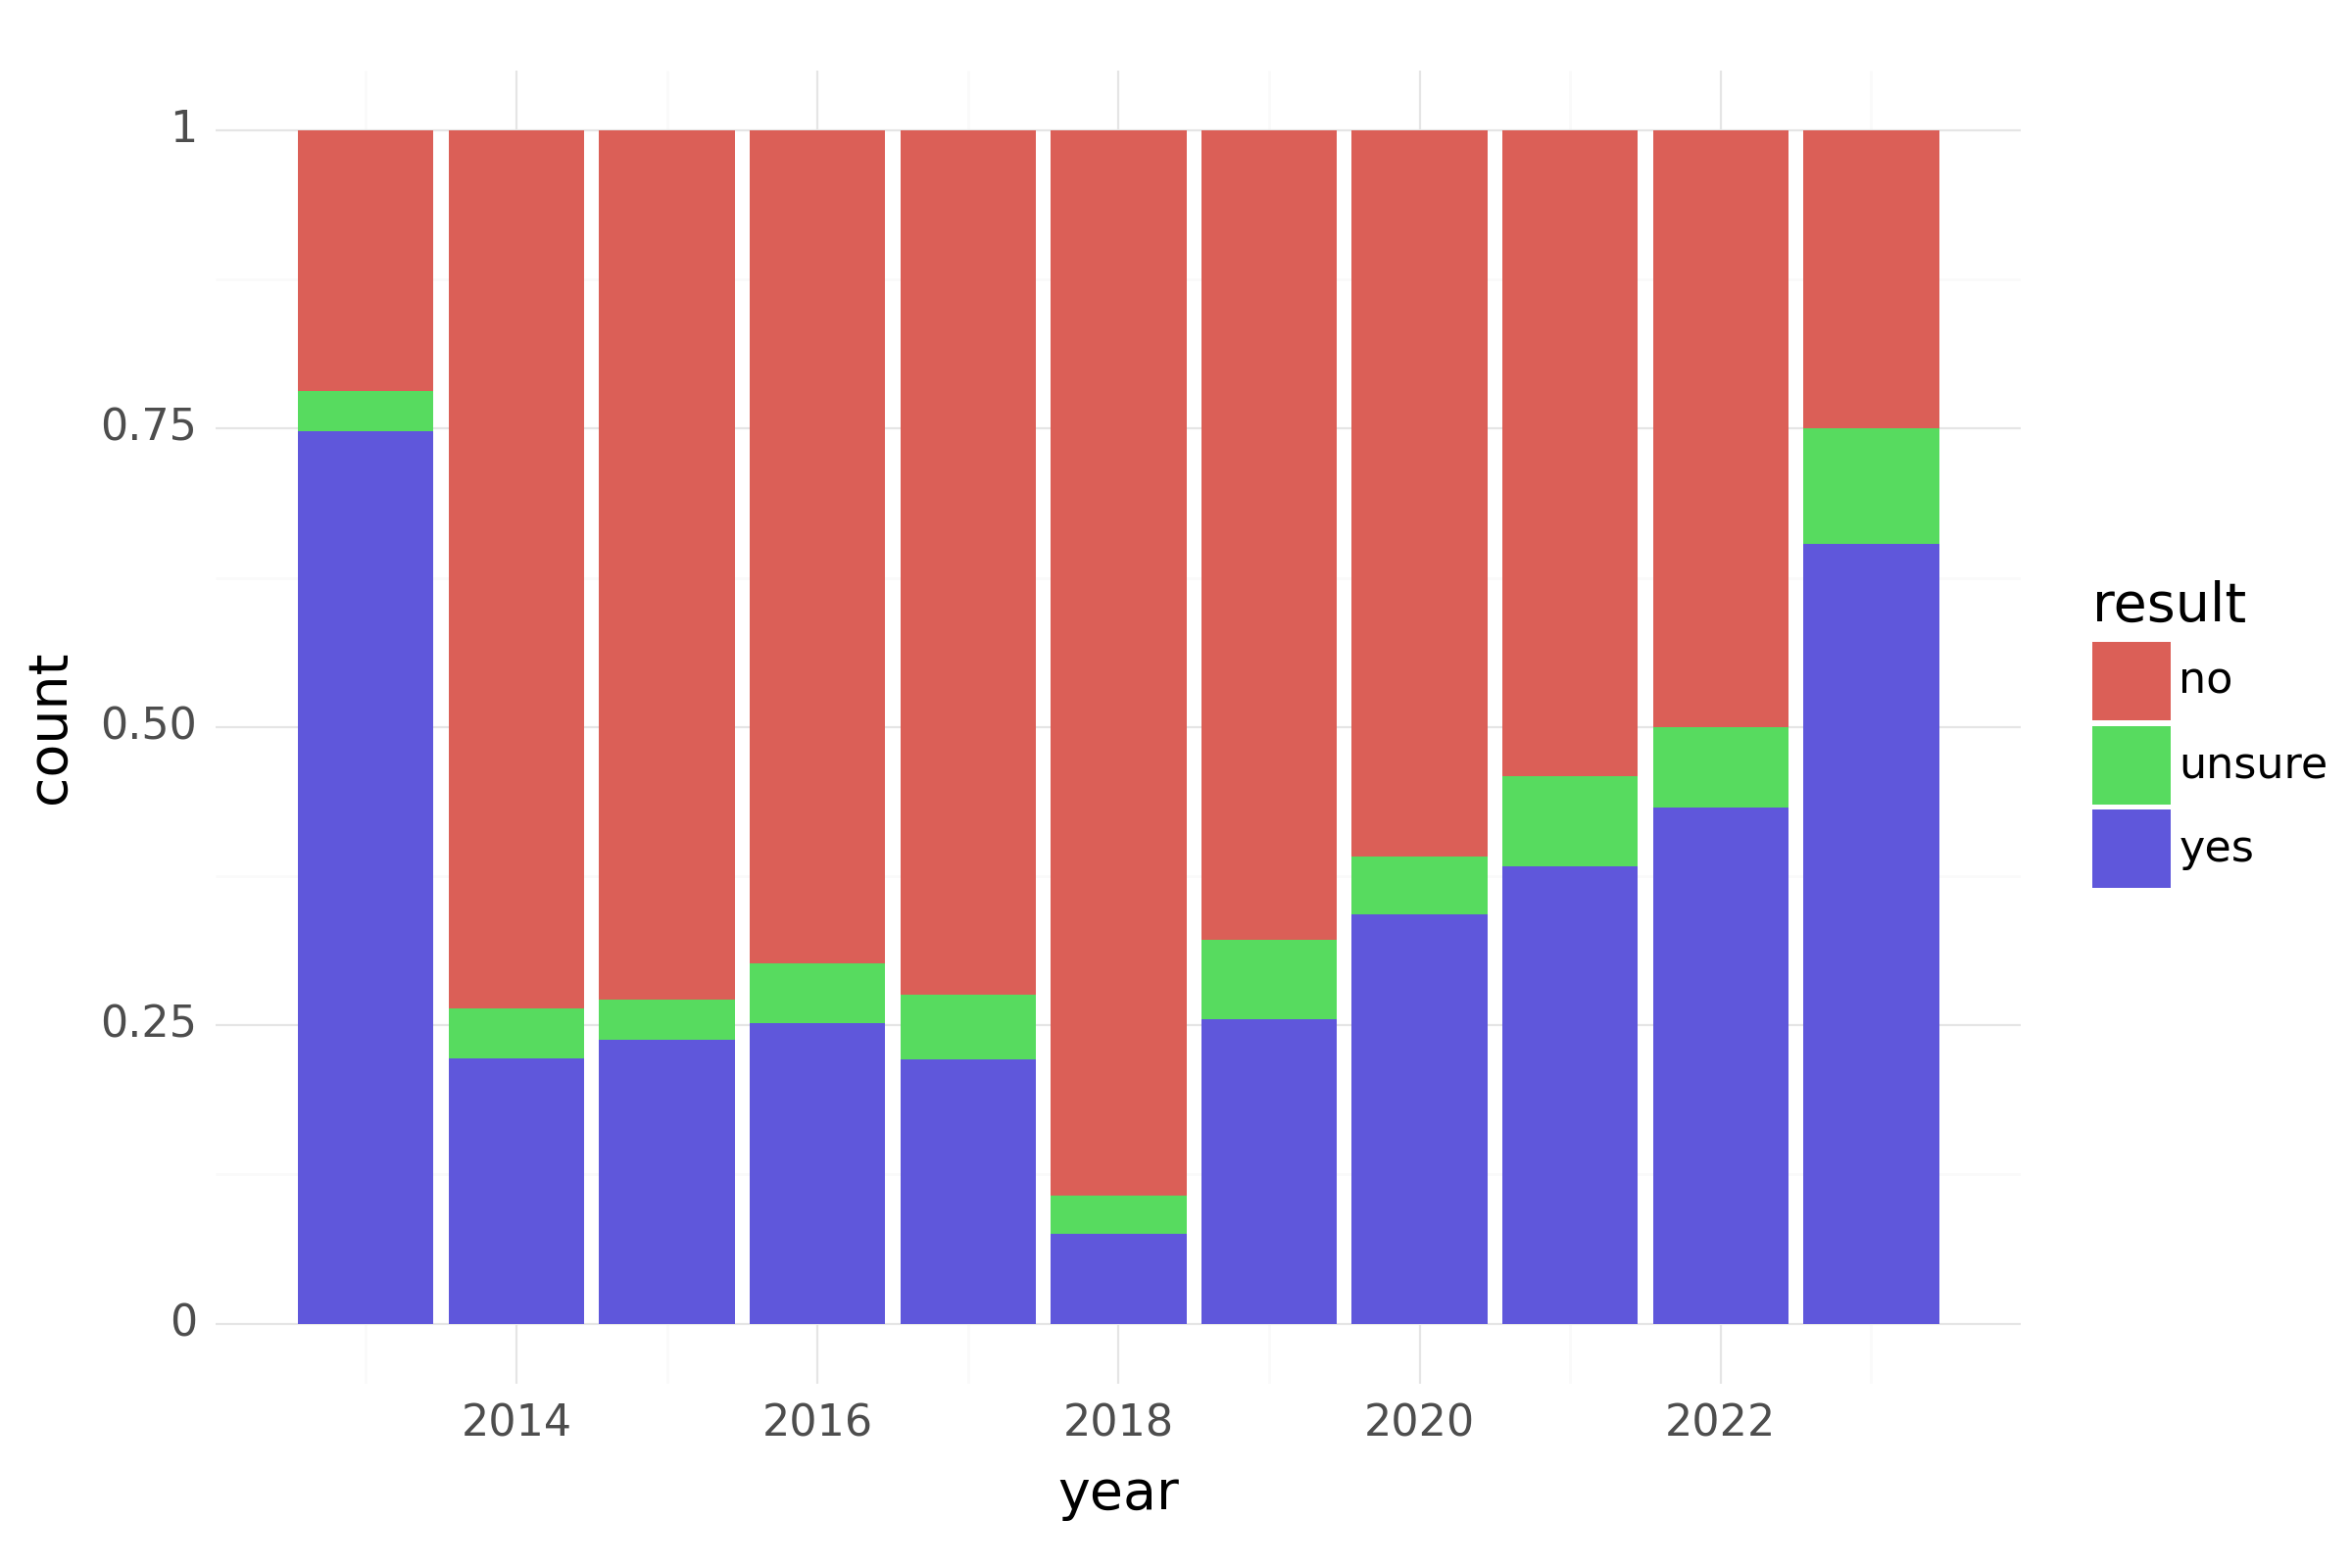

<Figure Size: (1200 x 800)>

In [ ]:
(ggplot(results, aes(x = "year", fill = "result")) + geom_bar(position = "fill"))

One of the other pieces of information we have about the tasks is the footprint size. In some projects, this variable is highly predictive. Here, the largest 20% of footprints are nearly 10x more likely to receive 'Yes building' responses.

In [ ]:
task_gdf["building_size_sq_meter"] = task_gdf["geometry"].to_crs(6933).area
task_gdf["building_size_sq_meter_quintile"] = pd.qcut(task_gdf["building_size_sq_meter"], 5, labels=False)

In [ ]:
task_gdf.groupby("building_size_sq_meter_quintile")["yes_building"].mean().reset_index()

,building_size_sq_meter_quintile,yes_building
0,0,0.058513
1,1,0.102687
2,2,0.192369
3,3,0.279107
4,4,0.404809


### Maps

Below, we bin tasks into equally sized hexagons. Notice that in some regions, most of the responses are affirmative, while in others, nearly all responses are negative.

In [ ]:
create_hex_map(task_gdf, 4)

<ipython-input-32-a0c22d98d972>:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



It's also possible to plot the individual footprints. Here we show just a sample of 1000 for speed.

In [ ]:
create_task_map(task_gdf.head(1000))

## Possible directions for the Red Cross <> Data Clinic collaboration:

### Tailoring insights

The charts and figures above are only cursory examples of insights that can be pulled. We will work with stakeholders to hone in on a suite of output that provide the most value to project leaders and the remaining lifecycle of the Missing Maps effort.

### Data filtering and export

Notebook users could define critera for remapping - such as all tasks with < 50% 'Yes building' responses - to idenitify which footprints should be considered unreliable and remapped. Once these criteria are applied, the resulting task geometries could be exported in formats suitable for MapRoulette, HOT Tasking Manager, etc. This feature would streamline the process of going from raw mapswipe outputs to features that can be directly loaded into tasking applications.

### User-response analysis:

User-level responses are available in the 'Results' data file and additional information is present in the 'Users' table. Users differ in their tendancies and response patterns. Some users, for instance, provide non-informative responses (e.g., giving the same response for every task). Others vary in their response habits - some are more conservative and require strict alignment between the footprint and the imagery, while others are willing to allow greater deviations.

A simple version of taking user behavior into account could be identifying and excluding the responses from users who have extremely low-variance responses. A more complicated approach could weight the task level results according to the characteristics of the users who responded to that task.

### Task agreement scores

Currently, an overall agreement score is provided for each task. This agreement score, called Fleiss' kappa quantifies the extent to which raters agree about a categorical rating. We believe we may have identified a small and easily addressable bug in the calculation that we would like to review with the Red Cross team.

There may be an opportunity to complement the existing score by differentiating between different types of disagreement, such as when some users disagree because some users are 'Yes building' and others are 'No building' compared to the case when some responses are 'Yes building' and others are 'Offset'.


In [ ]:
variable_name = "" # @param {type:"string"}


Here are our thresholds

A
B
C

# V1

In [ ]:
proj_code =  "-NcDh6AxOmfi4gC6XInw" # @param {type:"string"}


In [ ]:
all_projects_csv = "https://apps.mapswipe.org/api/projects/projects.csv"

In [ ]:
all_projects_csv_with_geometry = "https://apps.mapswipe.org/api/projects/projects_geom.geojson"

In [ ]:
project_task_gdf = read_agg_results(proj_code)

NameError: name 'read_agg_results' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Footprint size

## Task year

## Spatial Correlation

## User data

## Export

### MapRoulette

## Summary